### Imports

In [125]:
import os
import numpy as np
import pandas as pd
import importlib

import matplotlib.pyplot as plt

import findatree.io as io
import findatree.descriptions as descriptions

plt.style.use(r'C:\Repos\findatree\own.mplstyle')

### Definitions

In [3]:
# Define directories where processed hdf5s are stored
dir_hdf5 = r"C:\Data\lwf\processed\2020\hdf5"

### Load crowns' features of all hdf5s

In [58]:
# Get paths to all available hdf5 files
paths = [os.path.join(dir_hdf5, name) for name in os.listdir(dir_hdf5) if os.path.splitext(name)[-1] == '.hdf5']

# Init list of features, elements will pd.DataFrames
feats_terr = []
feats_photo = []
# Init list of features keys which will correspond to tnr identifier
feats_keys = []

for path in paths:
    # Load `crowns_human` data
    data, params_data = io.load_hdf5(path, groups = ['crowns_human'], features_only=True)
    
    # Append to feature/key lists
    feats_terr.append( pd.DataFrame(data['crowns_human']['features']['terrestrial']) )
    feats_photo.append( pd.DataFrame(data['crowns_human']['features']['photometric']) )
    feats_keys.append(int(params_data['crowns_human']['tnr']))

############## Combine terrestrial features
# Combine feats lists to one pd.DataFrame containing all tnrs
df_terr = pd.concat(
    feats_terr,
    keys=feats_keys,
    names=['tnr'],
    )
# Convert MultiIndex pd.DataFrame to standard pd.DataFrame by resetting tnr identifiers as index
df_terr.reset_index(level=['tnr'], inplace=True)
# Continuous relabeling of index
df_terr.reset_index(inplace=True, drop=True)

############## Combine photometric features
# Combine feats lists to one pd.DataFrame containing all tnrs
df_photo = pd.concat(
    feats_photo,
    keys=feats_keys,
    names=['tnr'],
    )
# Convert MultiIndex pd.DataFrame to standard pd.DataFrame by resetting tnr identifiers as index
df_photo.reset_index(level=['tnr'], inplace=True)
# Continuous relabeling of index
df_photo.reset_index(inplace=True, drop=True)

############## Combine terrestic and photometric features
df = pd.concat(
    [df_terr, df_photo],
    axis=1,  
)

### Inspect the features

#### Optionally print some infos about features

In [ ]:
print('-> Terrestrial features info:')
df_terr.info()
print()
print('-> Photometric features info:')
df_photo.info()
print()
print('-> Combined terrestrial and photometric features info:')
df.info()

#### Plot histograms

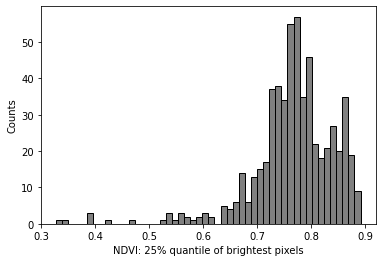

In [123]:
############### Define a query string to filter all features
query_str = 'ba >= 0'
# query_str = 'ba in [134]' # Select 'Gemeine Kiefer'
# query_str = 'ba in [118]' # Select 'Gemeine Fichte'
# query_str = 'ba in [100]' # Select Weißtanne'

############### Which feature to plot
# name = ('kkl', 'Kraft Baum Klasse')
# bins = range(0,6)

# name = ('ba', 'Baumart')
# bins = 100

# name = ('bk', 'Baumklasse')
# bins = 100

name = ('perc25_brightest_ndvi', r'NDVI: 25% quantile of brightest pixels')
bins = 50

# name = ('perc75_brightest_ndvi', r'NDVI: 75% quantile of brightest pixels')
# bins = 50

# name = ('median_brightest_ndvi', r'NDVI: Median of brightest pixels')
# bins = 50

############### Plot histogram
f = plt.figure(figsize= [6, 4])
ax = f.add_subplot(111)
_ = ax.hist(
    df.query(query_str)[name[0]],
    bins=bins,
    fc='grey',
    ec='black',
    )
_ = ax.set_ylabel('Counts')
_ = ax.set_xlabel(name[1])

#### List counts of tree species

In [108]:
# Get unique species ids and counts
ids, counts = np.unique(df['ba'], return_counts=True)

# Sort from highest count to lowest count
sort_idx= np.flip(np.argsort(counts))
counts = counts[sort_idx]
ids = ids[sort_idx]

# Get mapper dict from species id to name
mapper = descriptions.species_id_to_name()

print(f"Total number of trees: {len(df)}")
print()
print(f"{'id':<3}| {'name':<25}| {'count'}")
print('-'*40)
for id, count in zip(ids, counts):    
    print(f"{id:<3}, {mapper[id]:<25}: {count}")

Total number of trees: 590

id | name                     | count
----------------------------------------
134, Gemeine Kiefer           : 257
118, Gemeine Fichte           : 143
100, Weißtanne                : 63
20 , Rotbuche                 : 35
48 , Traubeneiche             : 29
116, Europäische Lärche       : 19
7  , Schwarzerle              : 10
51 , Stieleiche               : 9
10 , Gemeine Birke            : 8
36 , Kirsche                  : 5
13 , Hainbuche                : 5
22 , Gemeine Esche            : 3
5  , Bergahorn                : 2
35 , Aspe                     : 1
1  , Feldahorn                : 1


#### Scatter plot: 'Nadel Blatt Verlust' vs. Vegetation Indices for spec. tree species

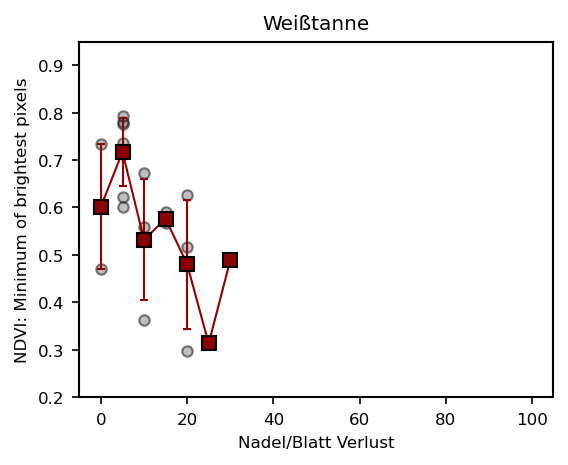

In [270]:
# Tree species mapper
mapper = descriptions.species_id_to_name()

############### Define a query string to filter all features
query_str = 'ba >= 0' # Select all tree species

ba_ids = [134] # Select 'Gemeine Kiefer'
ba_ids = [118] # Select 'Gemeine Fichte'
ba_ids = [100] # Select 'Weißtanne'

query_str = 'ba in @ba_ids' # Query for tree species
# query_str += ' and min_brightest_light > 2e-2' # Select all with min value of brightest px above fixed threshold
query_str += ' and kkl in [1,2]'

############### Which feature to plot
name_x = ('nbv', r'Nadel/Blatt Verlust')

# name_y = ('perc25_ndvi', r'NDVI: 25% quantile of all pixels')
# name_y = ('perc25_brightest_ndvi', r'NDVI: 25% quantile of brightest pixels')
# name_y = ('perc25_brightest_ndvire', r'NDVIRE: 25% quantile of brightest pixels')

############### Some plotting specs
xlim = [-5,105]
ylim = [0.2, 0.95] # For NDVI and NDVIRE
# ylim = [0., 0.4] # For NDRE

title_str = ''
for id in ba_ids: title_str += mapper[id].replace(' ', '') + '-'
title_str = title_str[:-1]

save_dir = r"C:\Users\flori\Documents\prof\lwf\plots\220722\nbv_vs_vegidx"
save_name = title_str + '__' + name_y[0] + '.pdf'

############### Plot histogram
x = np.array(df.query(query_str).loc[:, name_x[0]])
y = np.array(df.query(query_str).loc[:, name_y[0]])

f = plt.figure(figsize= [4, 3])
ax = f.add_subplot(111)

# Scatter plot
_ = ax.scatter(
    x,
    y,
    fc='grey',
    ec='k',
    alpha=0.5,
    )

# Errorbar plot for uniqe x values and respective y means
x_unique = np.unique(x)
y_unique = np.array([np.nanmean(y[np.where(x == xu)[0]]) for xu in x_unique])
y_unique_err = np.array([np.nanstd(y[np.where(x == xu)[0]]) for xu in x_unique])

_ = ax.errorbar(
    x_unique,
    y_unique,
    y_unique_err,
    fmt='-s',
    ms=7,
    color='darkred',
    mec='k',
    mfc='darkred',
    )


ax.set_title(title_str)
_ = ax.set_xlabel(name_x[1])
_ = ax.set_ylabel(name_y[1])
_ = ax.set_xlim(xlim)
_ = ax.set_ylim(ylim)

plt.savefig(os.path.join(save_dir, save_name), transparent=True)